# System Utilization

How many bikes are in use at any given time?

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from intervaltree import Interval, IntervalTree
from src.data.load_data import load_trip_data
%matplotlib inline

In [2]:
trip_data = load_trip_data()

In [3]:
# Create an interval tree with the start/end times. This is an efficient data
# structure for supporting queries for trips that overlap a specified point.
tree = IntervalTree(
    (Interval(start, end, id_)
     for id_, (start, end) in trip_data[["Start date", "End date"]].iterrows())
)

In [4]:
# Get a grid of times query points.
trip_range = trip_data["Start date"].min(), trip_data["End date"].max()
point_range = pd.date_range(*trip_range, freq="30min")

In [5]:
# Query the interval tree for those points.
utilization = pd.DataFrame(
    ((p, len(tree.at(p))) for p in point_range),
    columns=["datetime", "num_bikes_in_use"]
)

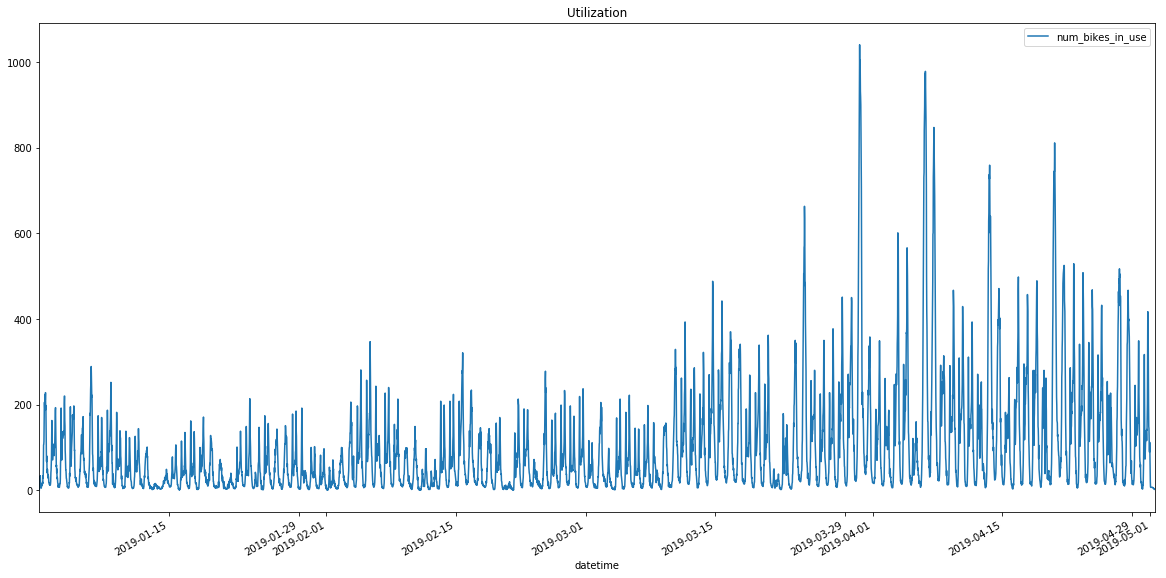

In [6]:
utilization.plot(
    x="datetime", y="num_bikes_in_use", kind="line", figsize=(20,10), title="Utilization")

In [7]:
utilization["day_of_week"] = utilization.datetime.apply(lambda x: x.day_name())
utilization["time"] = utilization.datetime.apply(lambda x: x.time())

In [8]:
hourly_utilization_stats = utilization.groupby(
    ["day_of_week", "time"]
).agg(
    {"num_bikes_in_use": [np.mean, np.std]}
)

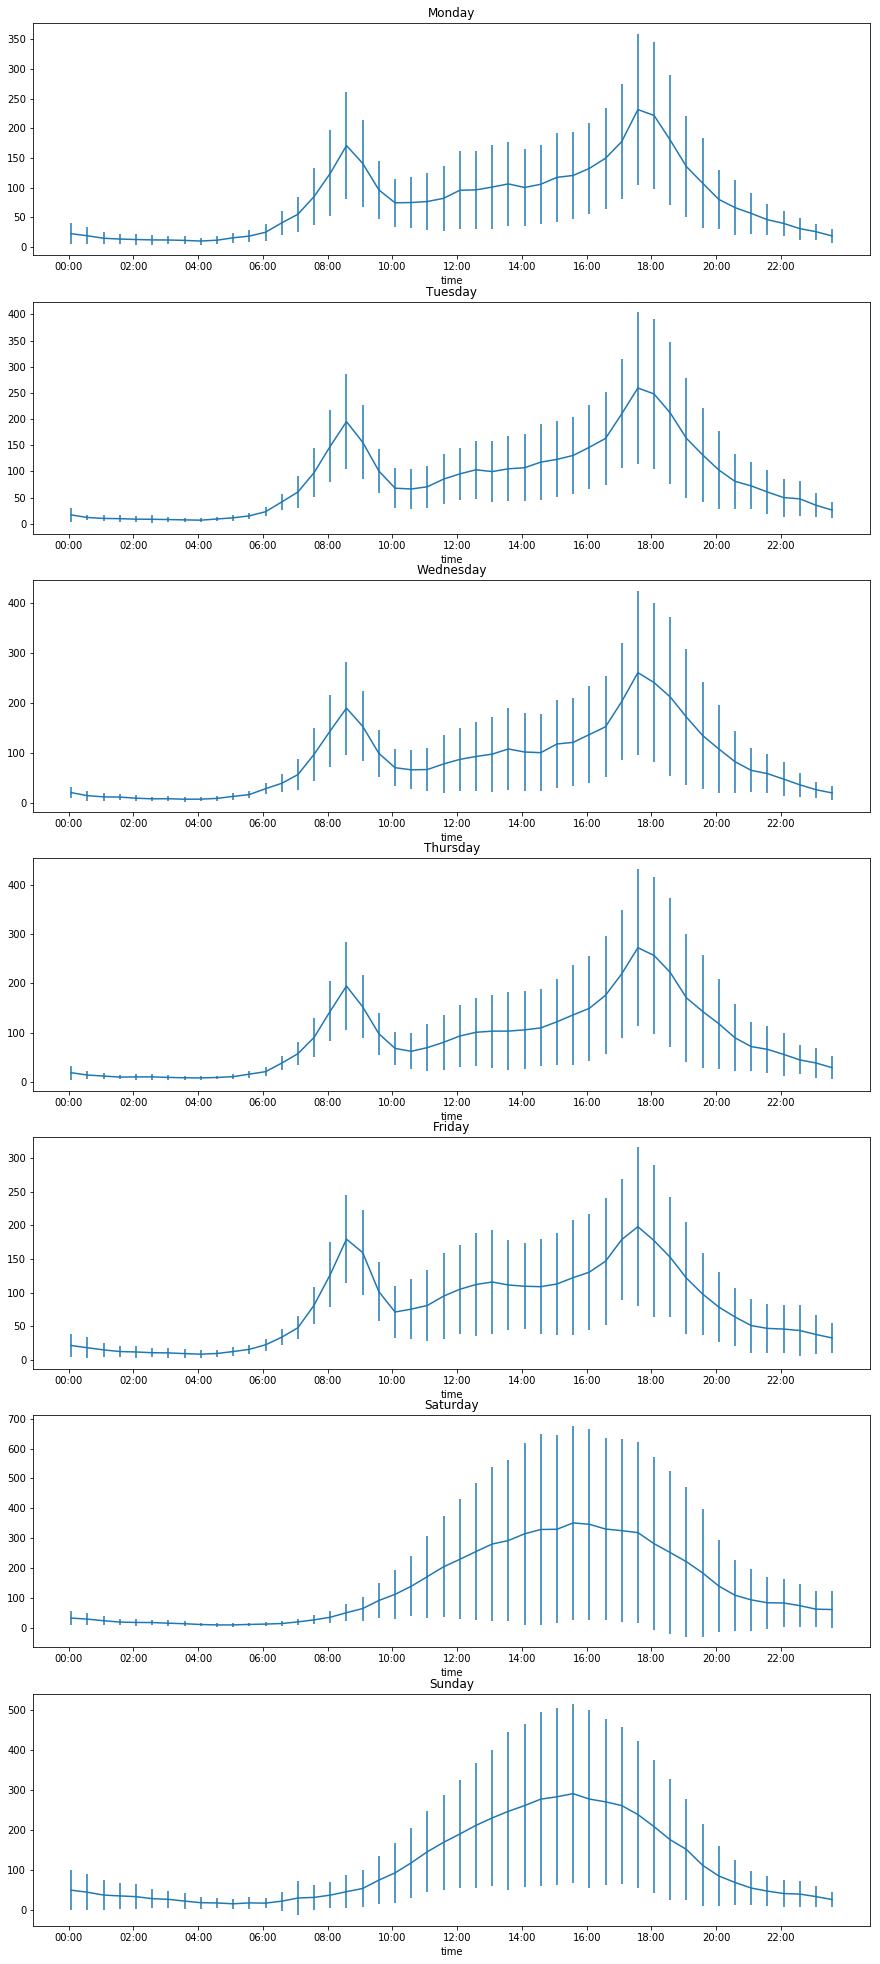

In [9]:
# Plots by day of week with one std error bars
plt.figure(figsize=(15, 35))

for i, day in enumerate([
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday"
]):
    filtered = hourly_utilization_stats[
        hourly_utilization_stats.index.get_level_values(0) == day]
    plt.subplot(7, 1, i + 1)
    plt.errorbar(
        filtered.index.get_level_values(1),
        filtered.num_bikes_in_use["mean"],
        yerr=filtered.num_bikes_in_use["std"]
    )
    plt.xticks([datetime.time(i) for i in range(0, 24, 2)])
    plt.title(day)